In [1]:
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import os
import scipy.stats as st
from scipy import signal
import cv2 as cv
from scipy.spatial.distance import cdist

In [2]:
img = Image.open("imsat TP3.JPG")
img2 = Image.open("imsat TP4.JPG")

In [3]:
cropped = np.zeros((347,365,3))
a = 0
b = 0
for i in range(853,1200):
    for j in range(461,826):
        
        cropped[a,b] = np.array(img.getpixel((i, j)))
        b = b + 1
    a = a + 1
    b = 0

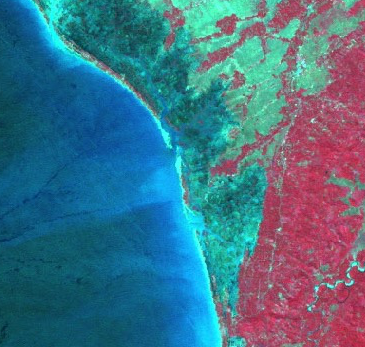

In [4]:
croppedImg = cropped.astype(int)
PIL_image = Image.fromarray(np.uint8(croppedImg)).convert('RGB')
PIL_image

<h1> Sobel

In [5]:
def sobel(image):
    
    Xconv = 0
    Xres = []
    Yconv = 0
    Yres = []
    
    Gx = [[-1,-2,-1],[0,0,0],[1,2,1]]
    Gy = [[-1,0,1],[-2,0,2],[-1,0,1]]
    
    for x in range(1,image.shape[0]-1):
        for y in range(1,image.shape[1]-1):
            add = 0
            for i in range(3):
                for j in range(3):
                    Xconv = Xconv + sum(image[(x-1)+i,(y-1)+j] * Gx[i][j])
                    Yconv = Yconv + sum(image[(x-1)+i,(y-1)+j] * Gy[i][j])
            
            Xres = np.append(Xres, Xconv)
            Yres = np.append(Yres, Yconv)
            
            Xconv = 0
            Yconv = 0
    
    Ximg = np.reshape(Xres, [345,363])
    Yimg = np.reshape(Yres, [345,363])
    
    return Ximg.astype(int), Yimg.astype(int)

<h1>Laplacien

In [22]:
def laplacien(image):
    
    Xconv = 0
    Xres = []
    
    Gx = [[0, 1, 0], [1, -4, 1], [0 ,1, 0]]
    
    for x in range(1,image.shape[0]-1):
        for y in range(1,image.shape[1]-1):
            add = 0
            for i in range(3):
                for j in range(3):
                    Xconv = Xconv + sum(image[(x-1)+i,(y-1)+j] * Gx[i][j])
            
            Xres = np.append(Xres, Xconv)
            
            Xconv = 0
    
    Ximg = np.reshape(Xres, [345,363])
    
    return Ximg.astype(int)

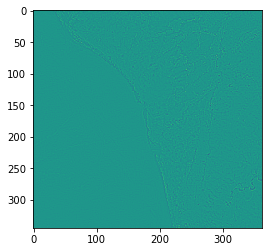

In [27]:
lap = laplacien(croppedImg)
plt.imshow(lap)

In [6]:
Xseb, Yseb = sobel(croppedImg)

In [7]:
tempX = Xseb
tempY = Yseb

In [8]:
def gradXY(Xseb, Yseb):
    for i in range(345):
        for j in range(363):
            if (Xseb[i][j] > 0):
                Xseb[i][j] = 1
            else:
                Xseb[i][j] = 0

            if (Yseb[i][j] > 0):
                Yseb[i][j] = 1
            else:
                Yseb[i][j] = 0
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)

    ax1 = fig.add_subplot(1,2,1)
    ax1.set_title("Gx")
    plt.imshow(Xseb,cmap='gray')

    ax2 = fig.add_subplot(1,2,2)
    ax2.set_title("Gy")
    plt.imshow(Yseb,cmap='gray')

    plt.show(block=True)

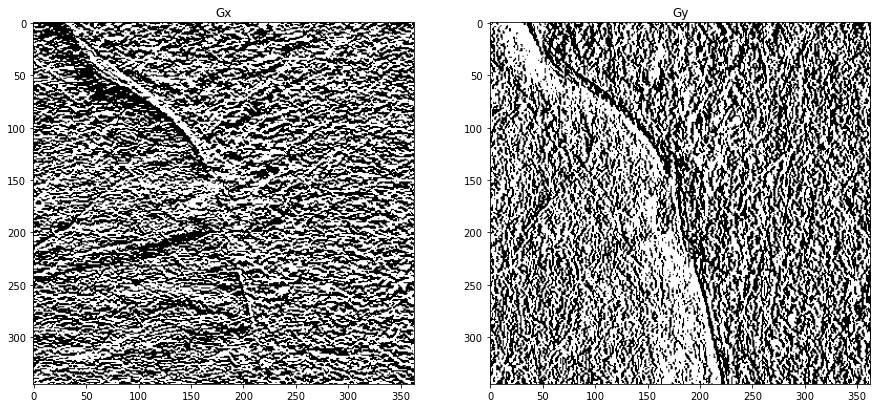

In [9]:
gradXY(Xseb,Yseb)

<h1>Amplitude et direction du Gradient

In [10]:
def amplitude_gradient(tempX, tempY):
    G = []
    for i in range(345):
        for j in range(363):
            G = np.append(G, np.sqrt(np.power(tempX[i][j],2) + np.power(tempY[i][j],2)))
    Gfinal =  np.reshape(G, [345,363])
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.imshow(Gfinal,cmap='gray')

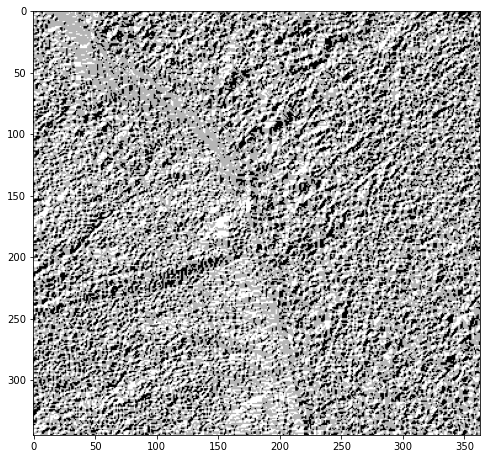

In [11]:
amplitude_gradient(tempX, tempY)

In [12]:
def direction_gradient(tempX, tempY):
    G = []
    for i in range(345):
        for j in range(363):
            if(tempX[i][j] != 0):
                G = np.append(G, np.arctan(tempY[i][j]/tempX[i][j]))
            else:
                G = np.append(G, 10)
    Gfinal =  np.reshape(G, [345,363])
    fig = plt.figure()
    fig.set_figheight(8)
    fig.set_figwidth(8)
    plt.imshow(Gfinal)

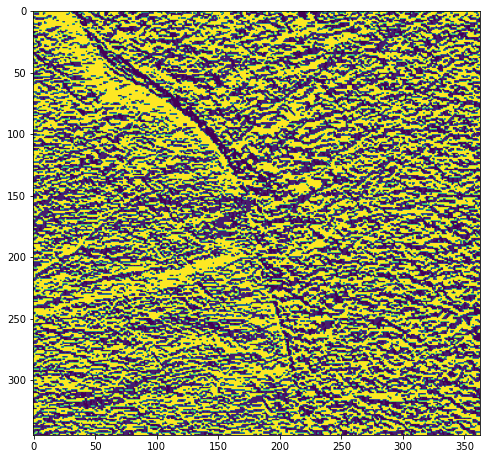

In [13]:
direction_gradient(tempX, tempY)

<h1>Comparaison

On remarque que chaque filtre donne un effet unique a l'image, cette effet nous permet de visuliser different asspet de l'image, comme pour de sobel on remarque qu'il definis les contour sur deux axes ce qui nous permet d'avoir un trait bien definis quelques soit l'orientation du contour, l'inconvenant avec cette methodes c'est les bruit qui est dans le rest de l'image.

Le filtre laplacien Les contoiour sont definis sans axes, et le resultat obtenu definis le coutour sans bruit sur l'image.

<h1>segmentation Par histograme

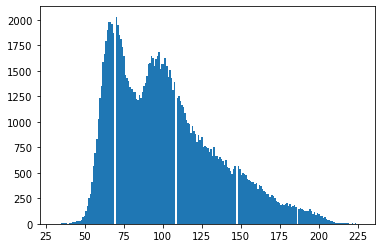

In [14]:
gray_cropped = np.array(ImageOps.grayscale(PIL_image))
plt.hist(gray_cropped.flatten(), bins = 200)
plt.show()

In [15]:
seg1 = (gray_cropped <= 85)
seg2 = (gray_cropped > 85)

In [16]:
segmented_img = np.zeros((gray_cropped.shape[0], gray_cropped.shape[1], 3))

In [17]:
segmented_img[seg1] = (1,0,0)
segmented_img[seg2] = (0,1,0)

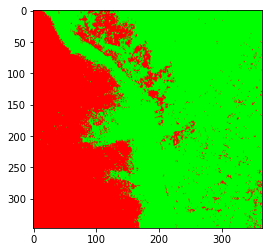

In [18]:
plt.imshow(segmented_img)

Pour les parametre j'ai analyser l'hisograme que j'ai obtenu a partir de l'image, puis j'ai diviser les valeurs correspendants au piques de l'hisograme (deux piques entre 0 et 85 et entre 85 et 215) après la segementation j'ai simplement changer la couleur de chaque region pour qu'elle soit visible sur l'image.

<h1>Kmeans segmentation

In [19]:
def kmeans(x,k, no_of_iterations):
    idx = np.random.choice(len(x), k, replace=False)
    
    centroids = x[idx, :]
     
    distances = cdist(x, centroids ,'euclidean') 
     
    points = np.array([np.argmin(i) for i in distances]) 
     
    for _ in range(no_of_iterations): 
        centroids = []
        for idx in range(k):
            temp_cent = x[points==idx].mean(axis=0) 
            centroids.append(temp_cent)
 
        centroids = np.vstack(centroids) 
         
        distances = cdist(x, centroids ,'euclidean')
        points = np.array([np.argmin(i) for i in distances])
         
    return points, centroids

In [20]:
def K_means_image_seg(img, k, itr):
    
    k_img = img.reshape(-1,3)
    lab, center = kmeans(k_img, k, itr)
    res = center[lab.flatten()]
    clustered = res.reshape(img.shape)
    plt.imshow(clustered.astype(int))

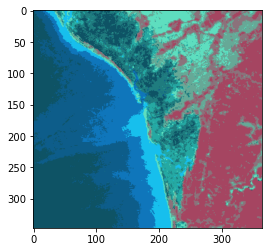

In [21]:
K_means_image_seg(croppedImg,10 , 50)

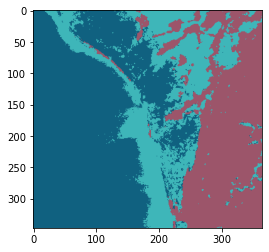

In [31]:
K_means_image_seg(croppedImg, 3 ,50)

Pour les parametre du Kmeans, au debut nous n'avons pas d'idée sur le nombre de class de l'image, donc j'ai commencer par 10 vosins, le resultat que j'ai eu se repporoche a l'image originale ce qui veux dir qu'on ne distique pas vraiment de difference entre les classes, j'ai ensuite reduit le nombre a 3 et comme ça nous pouvons clairement voir les 3 differentes classes (ocean (bleu), vegetation (rouge) et zone urbaine (bleuvert))